# Advanced Stance Analysis: Pro Ruling vs Pro Opposition

**Research Objective:** Analyze how different political affiliations (Pro Ruling vs Pro Opposition) use various keywords and in which stance (favor/against/neutral) they discuss them.

**Features:**
- Merged stance data from multiple runs
- Keyword bucketing (Economic, Social/Religious, Political/Policy, Leadership)
- Polarization analysis
- Party focus comparisons
- Heatmaps and advanced visualizations

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Color schemes
STANCE_COLORS = {
    'favor': '#2ecc71',     # Green
    'against': '#e74c3c',   # Red
    'neutral': '#95a5a6'    # Gray
}

PARTY_COLORS = {
    'pro ruling': '#FF6B35',      # Orange
    'pro opposition': '#004E89'   # Blue
}

BUCKET_COLORS = {
    'Economic': '#1abc9c',
    'Social/Religious': '#9b59b6',
    'Political/Policy': '#3498db',
    'Leadership': '#e67e22'
}

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Data Loading & Merging

In [26]:
# File paths
CSV_PATH = "/scratch/ziv_baretto/Research_X/Partisan-Discourse-on-X-English-/codes/6_stance/results/final_en_results/stance_results_37keywords.csv"

def load_data():
    """Load stance results from CSV."""
    if not Path(CSV_PATH).exists():
        raise FileNotFoundError(f"CSV file not found: {CSV_PATH}")
    
    df = pd.read_csv(CSV_PATH)
    print(f"Loaded {len(df):,} rows from {Path(CSV_PATH).name}")
    
    return df

df_raw = load_data()
print(f"\nColumns: {df_raw.columns.tolist()}")

Loaded 311,099 rows from stance_results_37keywords.csv

Columns: ['source_row', 'tweet', 'original_author', 'tweet_label', '_label_norm', 'keyword', 'subjects_scored', 'stance_gold', 'fewshot_raw', 'fewshot_label', 'fewshot_label_for_against', 'fewshot_reason', 'fewshot_shots_json']


In [27]:
# ============================================================================
# DATA PREPROCESSING
# ============================================================================

# Filter to only rows with valid stance labels
valid_stances = ['favor', 'against', 'neutral']
df = df_raw[df_raw['fewshot_label'].isin(valid_stances)].copy()

print(f"Total rows: {len(df_raw):,}")
print(f"Rows with valid stance labels: {len(df):,}")
print(f"Rows pending/invalid: {len(df_raw) - len(df):,}\n")

# Standardize columns
df['stance'] = df['fewshot_label']
df['party'] = df['_label_norm'].str.lower().str.strip()
df['keyword'] = df['keyword'].str.lower().str.strip()

# Filter to only pro ruling and pro opposition
df = df[df['party'].isin(['pro ruling', 'pro opposition'])]

print("=" * 50)
print("STANCE DISTRIBUTION")
print("=" * 50)
print(df['stance'].value_counts())

print("\n" + "=" * 50)
print("PARTY DISTRIBUTION")
print("=" * 50)
print(df['party'].value_counts())

print("\n" + "=" * 50)
print("KEYWORDS")
print("=" * 50)
keyword_counts = df['keyword'].value_counts()
print(f"Found {len(keyword_counts)} unique keywords:")
print(keyword_counts)

Total rows: 311,099
Rows with valid stance labels: 311,099
Rows pending/invalid: 0



STANCE DISTRIBUTION
stance
favor      148050
against    107155
neutral     55894
Name: count, dtype: int64

PARTY DISTRIBUTION
party
pro ruling        188055
pro opposition    123044
Name: count, dtype: int64

KEYWORDS
Found 37 unique keywords:
keyword
modi                98404
congress            37795
hindu               37294
rahulgandhi         23251
muslim              16913
kashmir             13355
china               11805
ucc                  7738
democracy            7612
msp                  5567
mahotsav             5455
aatmanirbhar         5386
sangh                4498
caa                  4297
farm laws            3573
hindutva             3326
ayodhya              2452
gdp                  2146
hathras              2112
bhakts               1886
unemployment         1649
minorities           1630
ram mandir           1615
islamists            1488
inflation            1424
shaheen bagh         1414
farmers protests     1114
lynching             1089
kashmiri pandits   

## 2. Keyword Bucket Classification

In [28]:
# ============================================================================
# KEYWORD BUCKETS
# ============================================================================

# KEYWORD_BUCKETS = {
#     'Economic': ['gdp', 'inflation', 'unemployment', 'msp', 'aatmanirbhar', 'economy', 'budget'],
#     'Social/Religious': ['ayodhya', 'minorities', 'islamists', 'sangh', 'hathras', 'ucc', 
#                          'hindu', 'hindus', 'muslim', 'muslims', 'ram'],
#     'Political/Policy': ['caa', 'farm', 'democracy', 'mahotsav', 'bjp', 'congress', 
#                          'election', 'protest', 'farmers'],
#     'Leadership': ['modi', 'bhakts', 'rahul', 'gandhi', 'pm']
# }

KEYWORD_BUCKETS = {
    'Economic & Development': [
        'aatmanirbhar', 'gdp', 'inflation', 'msp', 'unemployment', 'demonetisation'
    ],
    'Religious & Identity': [
        'ayodhya', 'bhakts', 'hindu', 'hindutva', 'islamists', 'muslim', 
        'ram mandir', 'sangh', 'sharia', 'kashmiri pandits'
    ],
    'Governance & Institutions': [
        'democracy', 'dictatorship', 'new parliament', 'modi', 'rahulgandhi', 
        'congress', 'spyware'
    ],
    'Legislation & Policy': [
        'caa', 'farm laws', 'ucc'
    ],
    'Social Justice & Human Rights': [
        'hathras', 'lynching', 'minorities', 'suicides'
    ],
    'Protests & Dissent': [
        'farmers protests', 'shaheen bagh'
    ],
    'Security & Geopolitics': [
        'balochistan', 'china', 'kashmir', 'mahotsav'
    ]
}

def get_bucket(keyword):
    """Assign a keyword to its bucket."""
    keyword_lower = keyword.lower()
    for bucket, keywords in KEYWORD_BUCKETS.items():
        for kw in keywords:
            if kw in keyword_lower:
                return bucket
    return 'Other'

# Apply bucket classification
df['bucket'] = df['keyword'].apply(get_bucket)

print("Keyword Bucket Distribution:")
print(df['bucket'].value_counts())
print("\nKeywords by Bucket:")
for bucket in df['bucket'].unique():
    keywords = df[df['bucket'] == bucket]['keyword'].unique()
    print(f"\n{bucket}: {list(keywords)}")

Keyword Bucket Distribution:


bucket
Governance & Institutions        168661
Religious & Identity              71028
Security & Geopolitics            31267
Economic & Development            16748
Legislation & Policy              15608
Social Justice & Human Rights      5131
Protests & Dissent                 2528
Other                               128
Name: count, dtype: int64

Keywords by Bucket:

Governance & Institutions: ['modi', 'spyware', 'democracy', 'dictatorship', 'congress', 'new parliament', 'rahulgandhi']

Religious & Identity: ['hindu', 'hindutva', 'kashmiri pandits', 'bhakts', 'ayodhya', 'islamists', 'sharia', 'sangh', 'muslim', 'ram mandir']

Security & Geopolitics: ['kashmir', 'china', 'balochistan', 'mahotsav']

Economic & Development: ['msp', 'demonetisation', 'aatmanirbhar', 'unemployment', 'inflation', 'gdp']

Social Justice & Human Rights: ['suicides', 'lynching', 'minorities', 'hathras']

Other: ['ratetvdebate']

Legislation & Policy: ['ucc', 'caa', 'farm laws']

Protests & Dissent: ['farme

## 3. Stance Comparison Visualizations

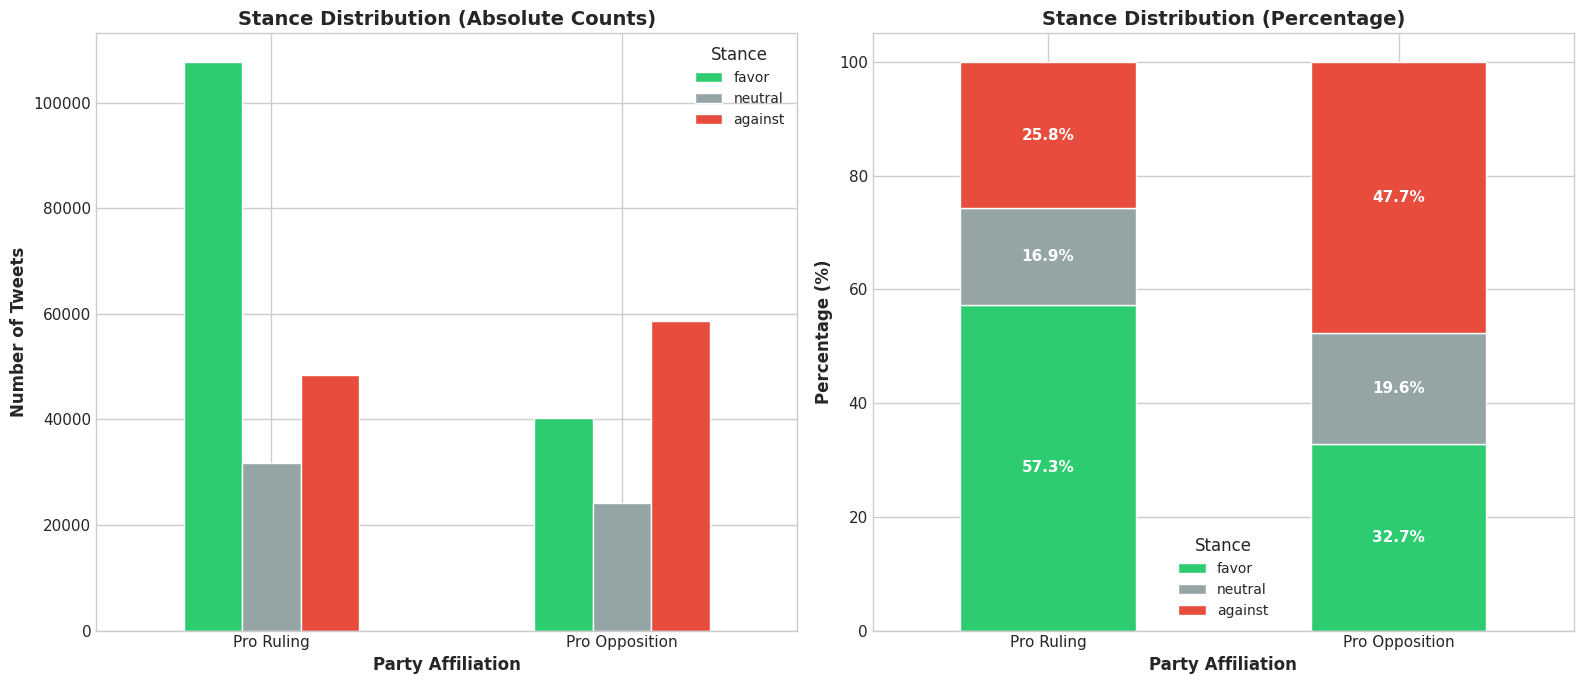

Saved: advanced_overall_stance.png


In [29]:
# ============================================================================
# OVERALL STANCE COMPARISON BY PARTY (Percentage)
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Create cross-tabulation
ct = pd.crosstab(df['party'], df['stance'])
ct = ct.reindex(['pro ruling', 'pro opposition'])
ct = ct[['favor', 'neutral', 'against']]

# Left: Absolute counts
ct.plot(kind='bar', ax=axes[0], 
        color=[STANCE_COLORS['favor'], STANCE_COLORS['neutral'], STANCE_COLORS['against']],
        edgecolor='white', linewidth=1)
axes[0].set_title('Stance Distribution (Absolute Counts)', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Party Affiliation', fontweight='bold')
axes[0].set_ylabel('Number of Tweets', fontweight='bold')
axes[0].set_xticklabels(['Pro Ruling', 'Pro Opposition'], rotation=0)
axes[0].legend(title='Stance', fontsize=10)

# Right: Percentages
ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100
ct_pct.plot(kind='bar', stacked=True, ax=axes[1],
            color=[STANCE_COLORS['favor'], STANCE_COLORS['neutral'], STANCE_COLORS['against']],
            edgecolor='white', linewidth=1)
axes[1].set_title('Stance Distribution (Percentage)', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Party Affiliation', fontweight='bold')
axes[1].set_ylabel('Percentage (%)', fontweight='bold')
axes[1].set_xticklabels(['Pro Ruling', 'Pro Opposition'], rotation=0)
axes[1].legend(title='Stance', fontsize=10)

# Add percentage labels
for i, party in enumerate(ct_pct.index):
    cumsum = 0
    for stance in ['favor', 'neutral', 'against']:
        val = ct_pct.loc[party, stance]
        if val > 5:
            axes[1].text(i, cumsum + val/2, f'{val:.1f}%', 
                        ha='center', va='center', fontsize=11, fontweight='bold', color='white')
        cumsum += val

plt.tight_layout()
plt.savefig('advanced_overall_stance.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: advanced_overall_stance.png")

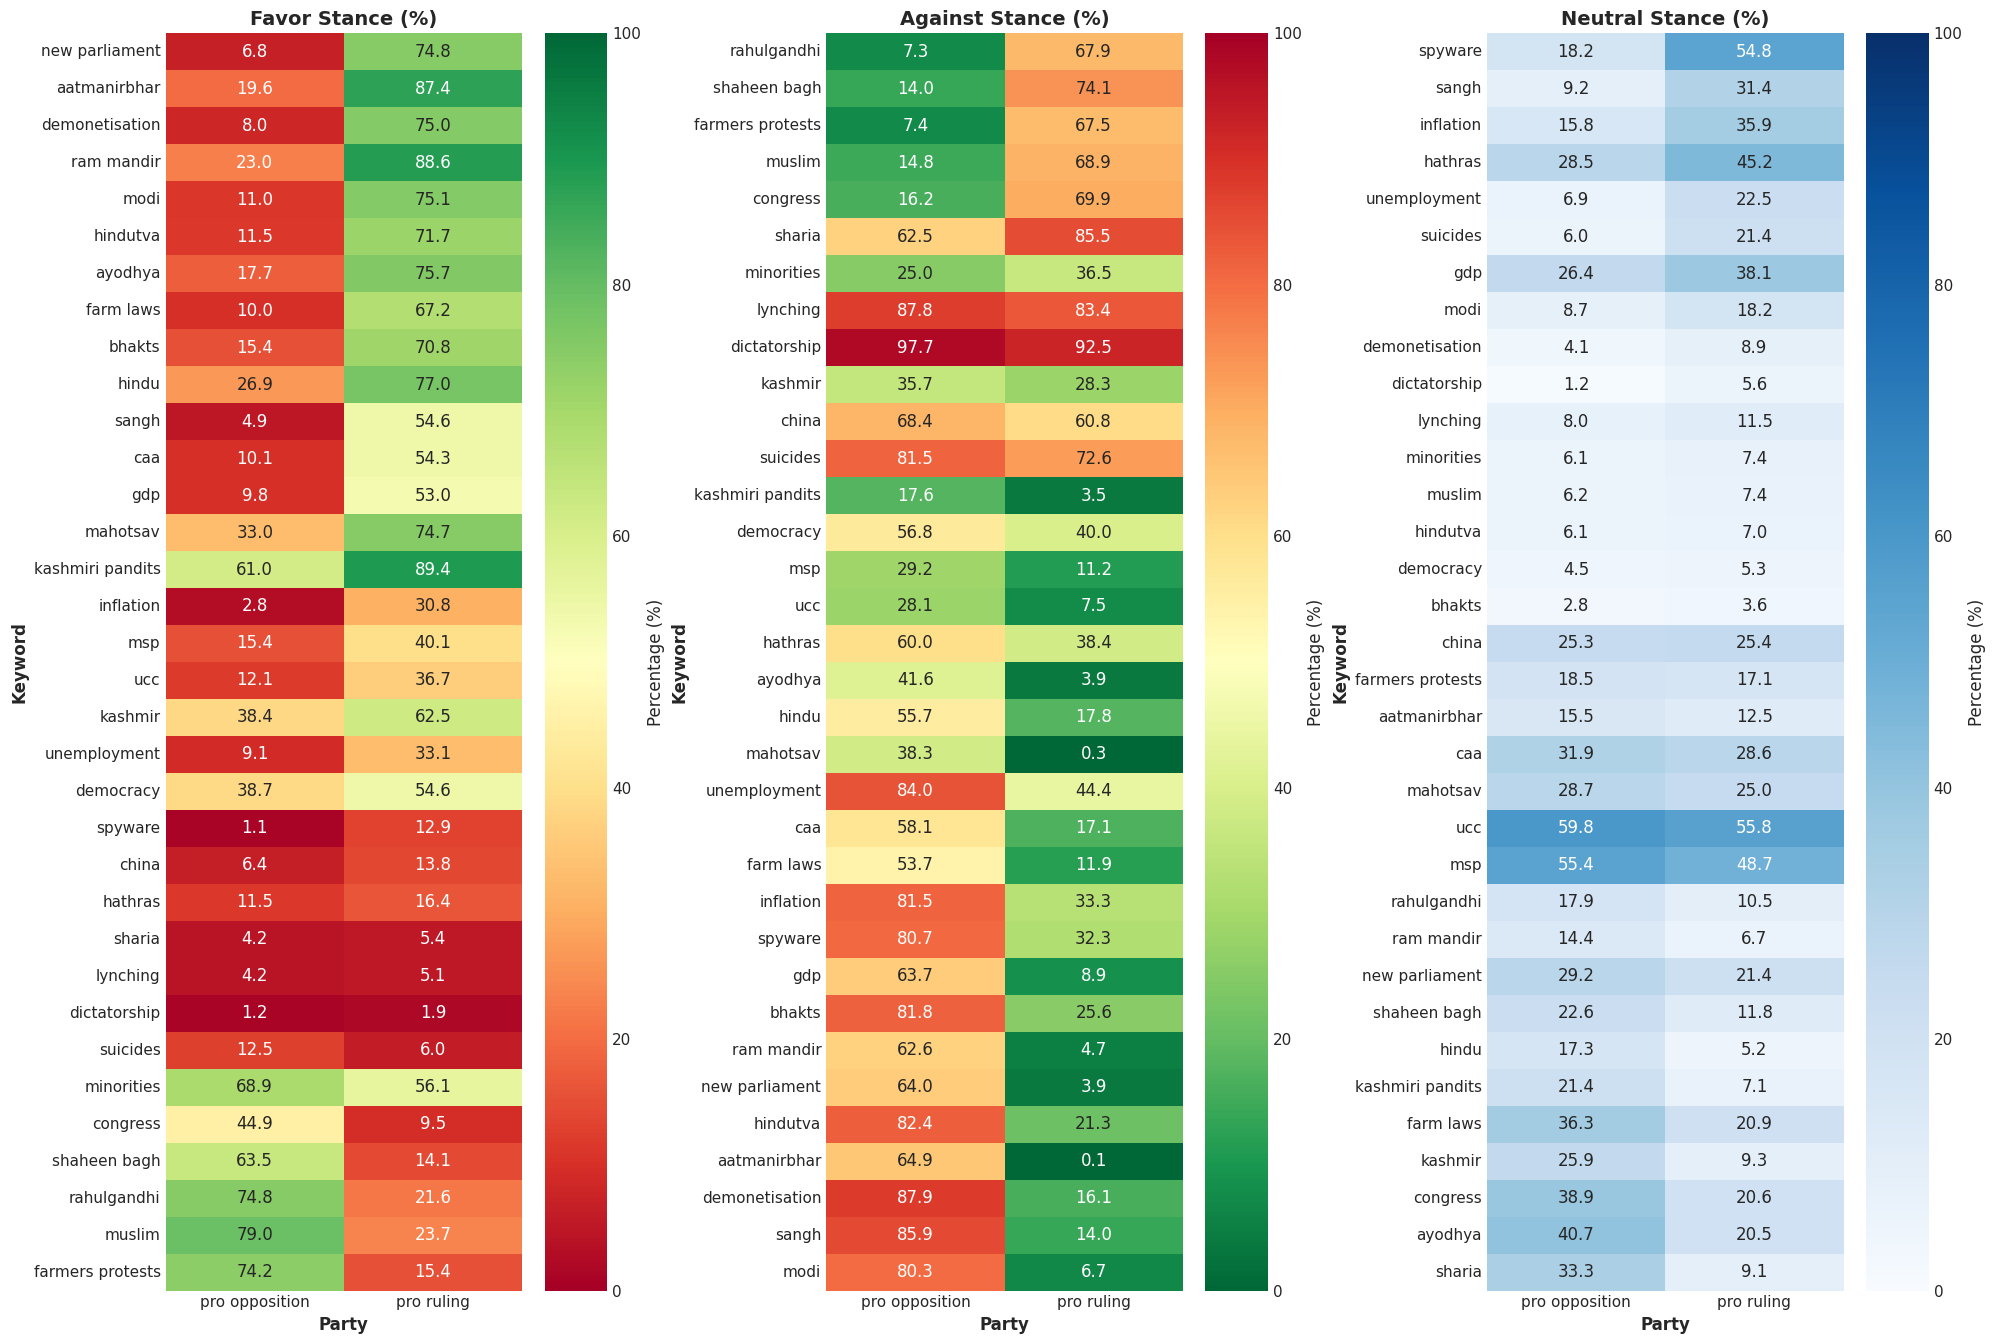

Saved: stance_heatmap_by_keyword.png


In [30]:
# ============================================================================
# STANCE HEATMAP BY KEYWORD AND PARTY
# ============================================================================

# Calculate stance percentages for each keyword-party combination
def create_stance_matrix(df, stance_type):
    """Create a matrix of stance percentages for heatmap."""
    cross = pd.crosstab([df['keyword'], df['party']], df['stance'], normalize='index') * 100
    
    # Pivot for heatmap format
    if stance_type in cross.columns:
        matrix = cross[stance_type].unstack(level='party')
        return matrix
    return None

# Get keywords with sufficient data
keyword_party_counts = df.groupby(['keyword', 'party']).size().unstack(fill_value=0)
valid_keywords = keyword_party_counts[(keyword_party_counts >= 20).all(axis=1)].index.tolist()

if len(valid_keywords) > 0:
    df_filtered = df[df['keyword'].isin(valid_keywords)]
    
    fig, axes = plt.subplots(1, 3, figsize=(20, max(8, len(valid_keywords)*0.4)))
    
    for idx, stance in enumerate(['favor', 'against', 'neutral']):
        matrix = create_stance_matrix(df_filtered, stance)
        if matrix is not None:
            # Sort by difference between parties
            if 'pro ruling' in matrix.columns and 'pro opposition' in matrix.columns:
                matrix['diff'] = matrix['pro ruling'] - matrix['pro opposition']
                matrix = matrix.sort_values('diff', ascending=False)
                matrix = matrix.drop('diff', axis=1)
            
            sns.heatmap(matrix, annot=True, fmt='.1f', cmap='RdYlGn' if stance == 'favor' else ('RdYlGn_r' if stance == 'against' else 'Blues'),
                       ax=axes[idx], cbar_kws={'label': 'Percentage (%)'}, vmin=0, vmax=100)
            axes[idx].set_title(f'{stance.capitalize()} Stance (%)', fontweight='bold', fontsize=14)
            axes[idx].set_xlabel('Party', fontweight='bold')
            axes[idx].set_ylabel('Keyword', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('stance_heatmap_by_keyword.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: stance_heatmap_by_keyword.png")
else:
    print("Not enough keywords with sufficient data for heatmap.")

## 4. Polarization Analysis

In [31]:
# ============================================================================
# CALCULATE POLARIZATION SCORES
# ============================================================================

def calculate_polarization(df):
    """Calculate how polarizing each keyword is between parties.
    
    Polarization = |Pro_Ruling_Favor% - Pro_Opposition_Favor%| + |Pro_Ruling_Against% - Pro_Opposition_Against%|
    Higher score = more polarizing (parties have very different stances)
    """
    results = []
    
    for keyword in df['keyword'].unique():
        kw_df = df[df['keyword'] == keyword]
        
        ruling = kw_df[kw_df['party'] == 'pro ruling']
        opposition = kw_df[kw_df['party'] == 'pro opposition']
        
        if len(ruling) < 10 or len(opposition) < 10:
            continue
        
        # Calculate stance percentages
        ruling_pct = ruling['stance'].value_counts(normalize=True) * 100
        opp_pct = opposition['stance'].value_counts(normalize=True) * 100
        
        # Get percentages (default 0 if stance not present)
        r_favor = ruling_pct.get('favor', 0)
        r_against = ruling_pct.get('against', 0)
        r_neutral = ruling_pct.get('neutral', 0)
        
        o_favor = opp_pct.get('favor', 0)
        o_against = opp_pct.get('against', 0)
        o_neutral = opp_pct.get('neutral', 0)
        
        # Polarization score
        polarization = abs(r_favor - o_favor) + abs(r_against - o_against)
        
        # Stance divergence: positive = ruling favors more, negative = opposition favors more
        stance_divergence = (r_favor - r_against) - (o_favor - o_against)
        
        results.append({
            'keyword': keyword,
            'bucket': get_bucket(keyword),
            'ruling_favor': r_favor,
            'ruling_against': r_against,
            'ruling_neutral': r_neutral,
            'opp_favor': o_favor,
            'opp_against': o_against,
            'opp_neutral': o_neutral,
            'polarization_score': polarization,
            'stance_divergence': stance_divergence,
            'ruling_count': len(ruling),
            'opp_count': len(opposition)
        })
    
    return pd.DataFrame(results).sort_values('polarization_score', ascending=False)

polarization_df = calculate_polarization(df)
print("Top 10 Most Polarizing Keywords:")
print(polarization_df.head(10)[['keyword', 'bucket', 'polarization_score', 'stance_divergence', 'ruling_favor', 'opp_favor', 'ruling_against', 'opp_against']].to_string())

Top 10 Most Polarizing Keywords:
             keyword                     bucket  polarization_score  stance_divergence  ruling_favor  opp_favor  ruling_against  opp_against
9     demonetisation     Economic & Development          138.885468         138.885468     75.000000   7.974138       16.071429    87.931034
0               modi  Governance & Institutions          137.703982         137.703982     75.080184  10.996604        6.671935    80.292337
23      aatmanirbhar     Economic & Development          132.636302         132.636302     87.407828  19.587629        0.132350    64.948454
32    new parliament  Governance & Institutions          128.123271         128.123271     74.777448   6.779661        3.857567    63.983051
34        ram mandir       Religious & Identity          123.412773         123.412773     88.556470  23.021583        4.712042    62.589928
19             sangh       Religious & Identity          121.586740         121.586740     54.628052   4.932408       13.

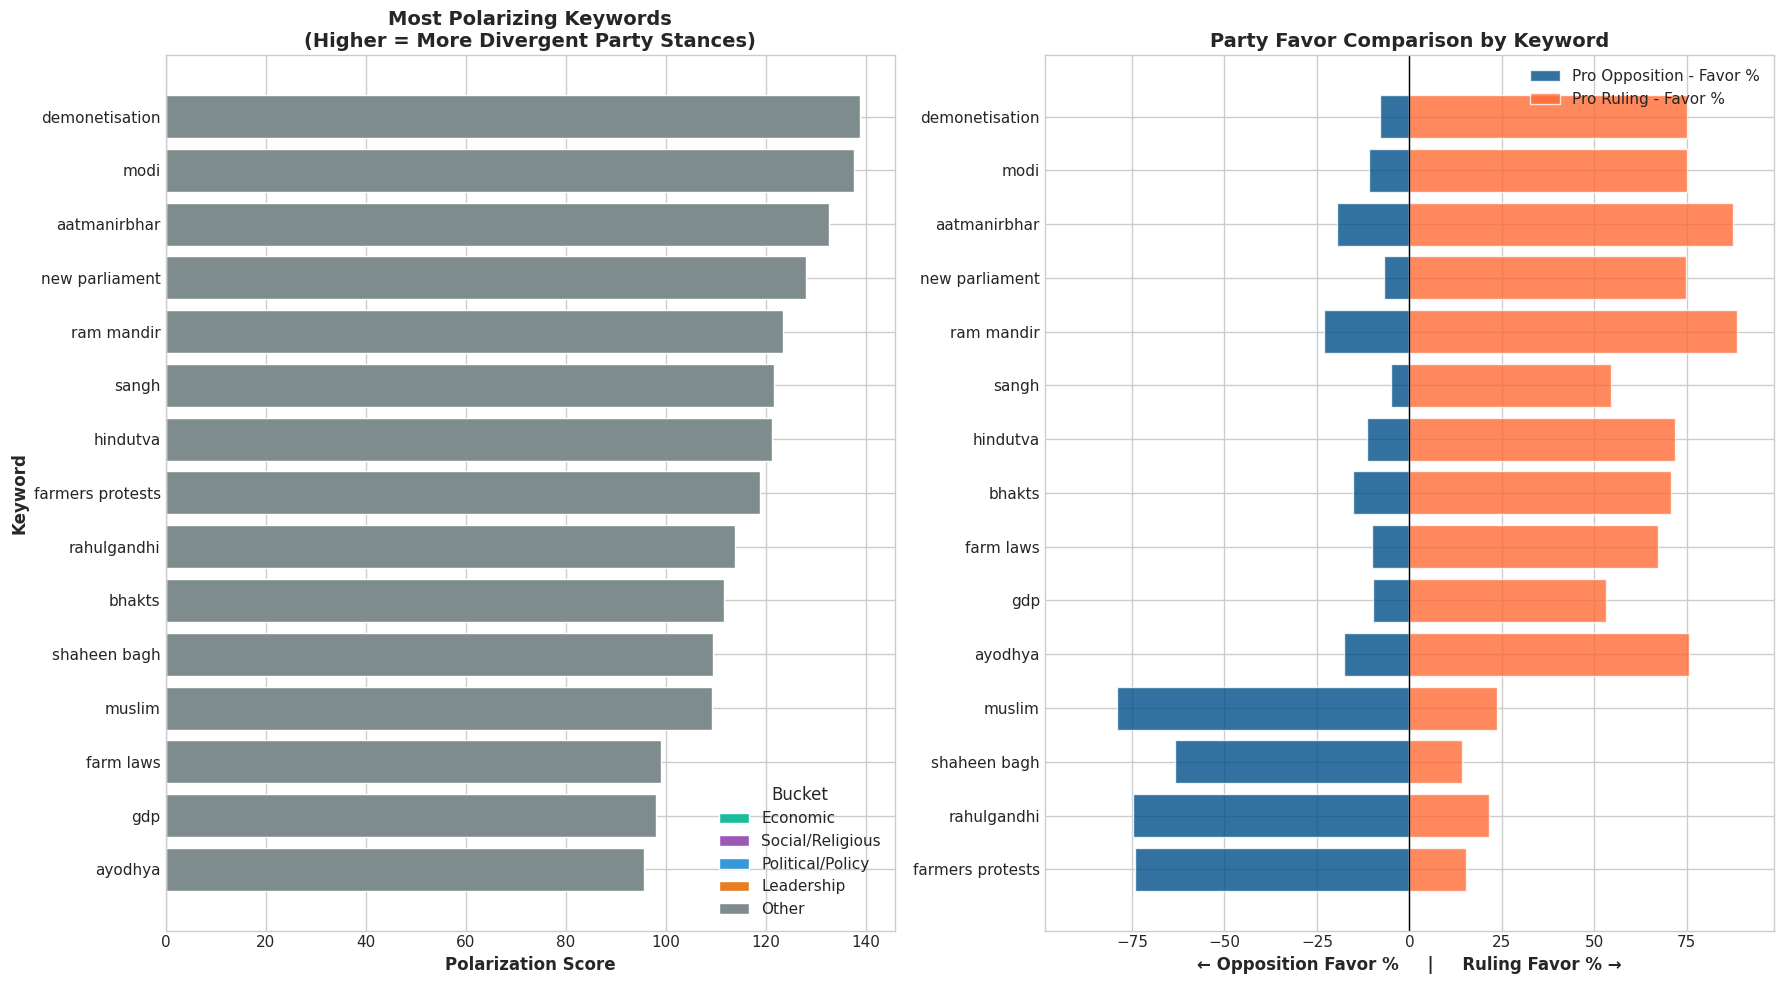

Saved: polarization_analysis.png


In [32]:
# ============================================================================
# POLARIZATION VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Sort by polarization score
pol_df = polarization_df.head(15).copy()

# Left: Polarization Score Bar Chart
colors = [BUCKET_COLORS.get(b, '#7f8c8d') for b in pol_df['bucket']]
bars = axes[0].barh(pol_df['keyword'], pol_df['polarization_score'], color=colors, edgecolor='white')
axes[0].set_xlabel('Polarization Score', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Keyword', fontweight='bold', fontsize=12)
axes[0].set_title('Most Polarizing Keywords\n(Higher = More Divergent Party Stances)', fontweight='bold', fontsize=14)
axes[0].invert_yaxis()

# Add legend for buckets
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=bucket) for bucket, color in BUCKET_COLORS.items()]
legend_elements.append(Patch(facecolor='#7f8c8d', label='Other'))
axes[0].legend(handles=legend_elements, loc='lower right', title='Bucket')

# Right: Stance Divergence (butterfly chart)
pol_df_sorted = polarization_df.head(15).sort_values('stance_divergence')

# Create butterfly chart showing favor % for each party
y_pos = range(len(pol_df_sorted))

# Pro Opposition (left side, negative)
axes[1].barh(y_pos, -pol_df_sorted['opp_favor'], color=PARTY_COLORS['pro opposition'], 
             label='Pro Opposition - Favor %', alpha=0.8)
# Pro Ruling (right side, positive)
axes[1].barh(y_pos, pol_df_sorted['ruling_favor'], color=PARTY_COLORS['pro ruling'], 
             label='Pro Ruling - Favor %', alpha=0.8)

axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(pol_df_sorted['keyword'])
axes[1].axvline(0, color='black', linewidth=1)
axes[1].set_xlabel('← Opposition Favor %     |     Ruling Favor % →', fontweight='bold', fontsize=12)
axes[1].set_title('Party Favor Comparison by Keyword', fontweight='bold', fontsize=14)
axes[1].legend(loc='upper right')

# Set symmetric limits
max_val = max(pol_df_sorted['opp_favor'].max(), pol_df_sorted['ruling_favor'].max())
axes[1].set_xlim(-max_val - 10, max_val + 10)

plt.tight_layout()
plt.savefig('polarization_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: polarization_analysis.png")

## 5. Bucket-wise Analysis

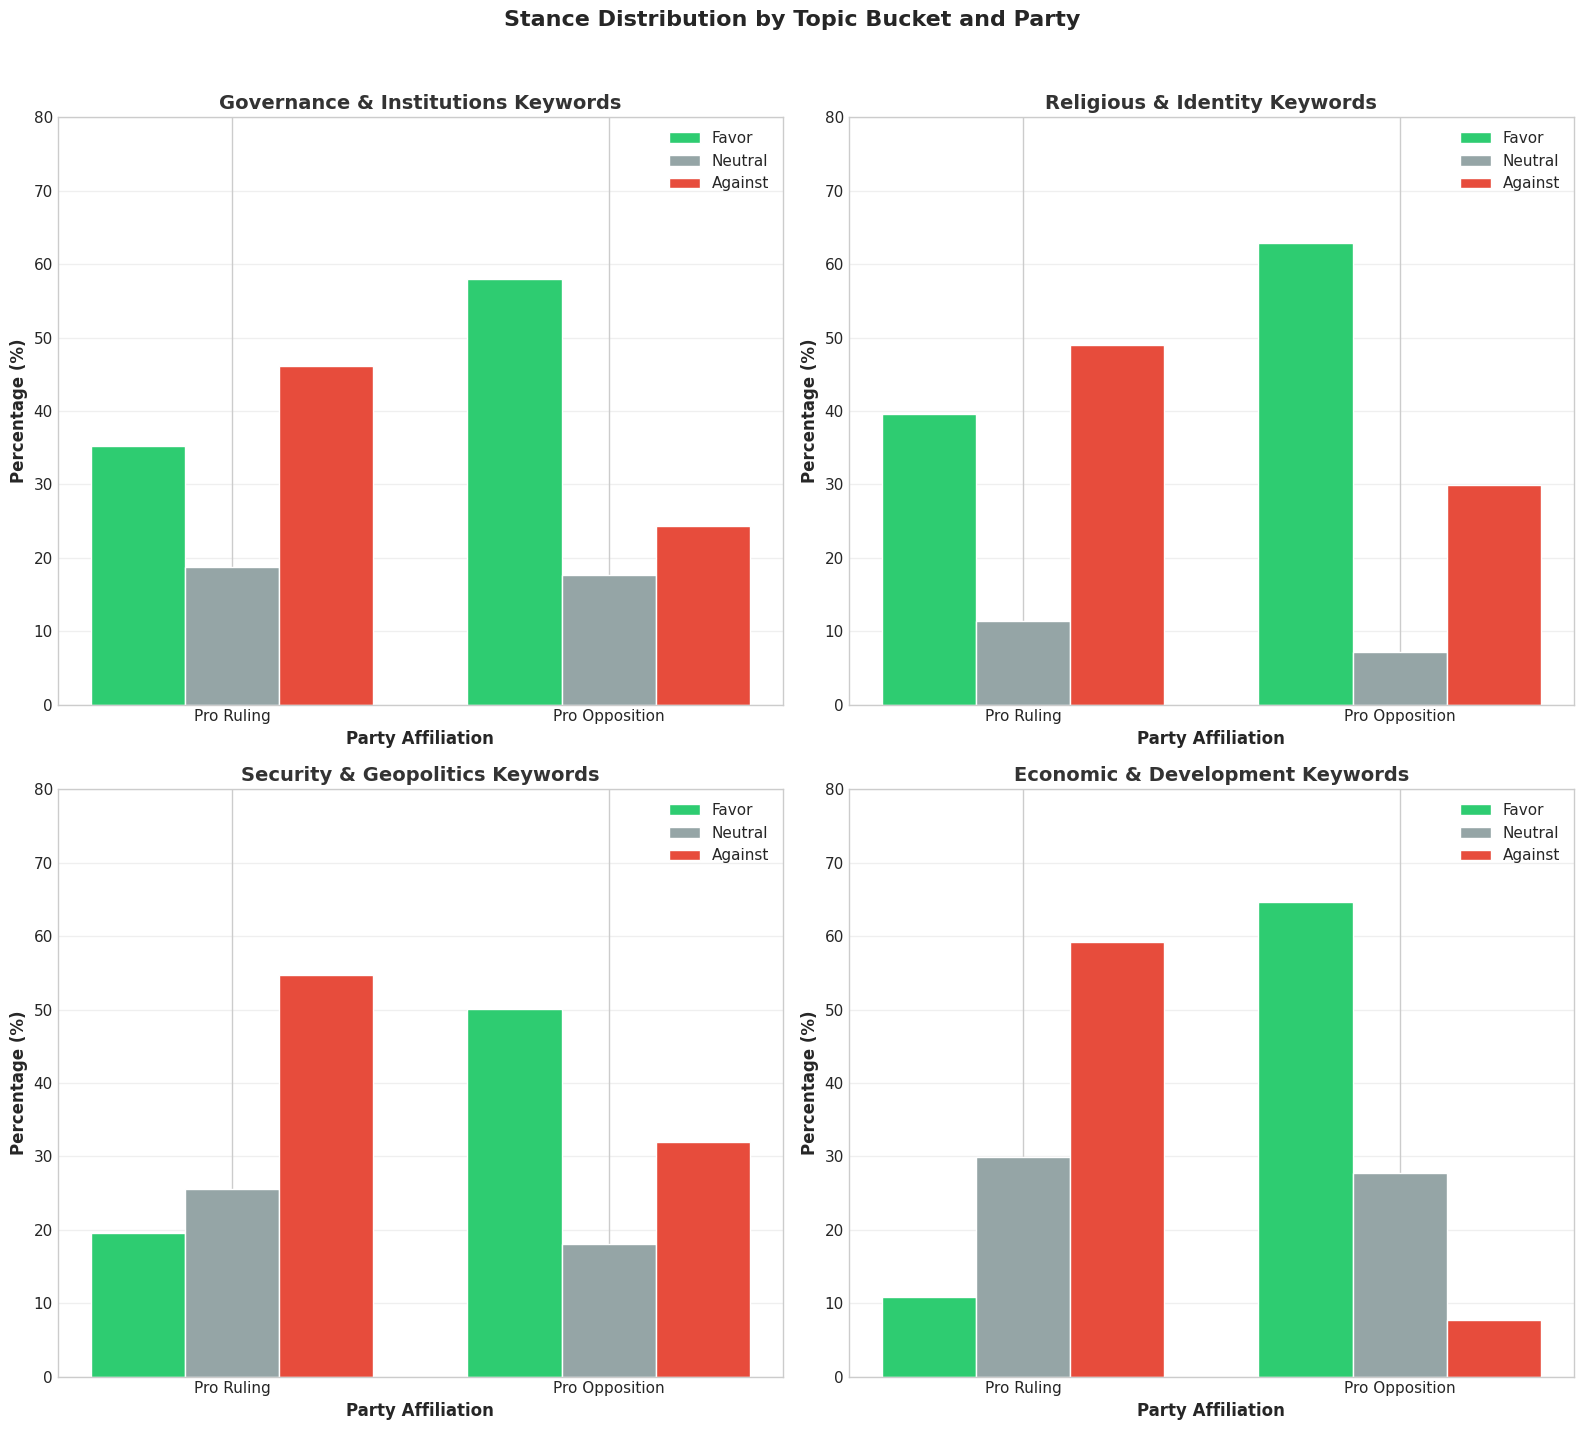

Saved: bucket_stance_analysis.png


In [33]:
# ============================================================================
# BUCKET-WISE STANCE ANALYSIS
# ============================================================================

# Aggregate by bucket and party
bucket_party_stance = df.groupby(['bucket', 'party', 'stance']).size().reset_index(name='count')
bucket_party_total = df.groupby(['bucket', 'party']).size().reset_index(name='total')
bucket_party_stance = bucket_party_stance.merge(bucket_party_total, on=['bucket', 'party'])
bucket_party_stance['percentage'] = bucket_party_stance['count'] / bucket_party_stance['total'] * 100

# Get unique buckets (excluding 'Other' if empty)
buckets = [b for b in df['bucket'].unique() if b != 'Other' or len(df[df['bucket'] == 'Other']) > 0]

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, bucket in enumerate(buckets[:4]):
    bucket_data = bucket_party_stance[bucket_party_stance['bucket'] == bucket]
    
    # Pivot for plotting
    pivot = bucket_data.pivot_table(index='party', columns='stance', values='percentage', fill_value=0)
    pivot = pivot.reindex(columns=['favor', 'neutral', 'against'], fill_value=0)
    
    x = np.arange(len(pivot.index))
    width = 0.25
    
    axes[idx].bar(x - width, pivot['favor'], width, label='Favor', color=STANCE_COLORS['favor'])
    axes[idx].bar(x, pivot['neutral'], width, label='Neutral', color=STANCE_COLORS['neutral'])
    axes[idx].bar(x + width, pivot['against'], width, label='Against', color=STANCE_COLORS['against'])
    
    axes[idx].set_xlabel('Party Affiliation', fontweight='bold')
    axes[idx].set_ylabel('Percentage (%)', fontweight='bold')
    axes[idx].set_title(f'{bucket} Keywords', fontweight='bold', fontsize=14,
                       color=BUCKET_COLORS.get(bucket, '#333'))
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(['Pro Ruling', 'Pro Opposition'])
    axes[idx].legend(loc='upper right')
    axes[idx].set_ylim(0, 80)
    axes[idx].grid(axis='y', alpha=0.3)

plt.suptitle('Stance Distribution by Topic Bucket and Party', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('bucket_stance_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: bucket_stance_analysis.png")

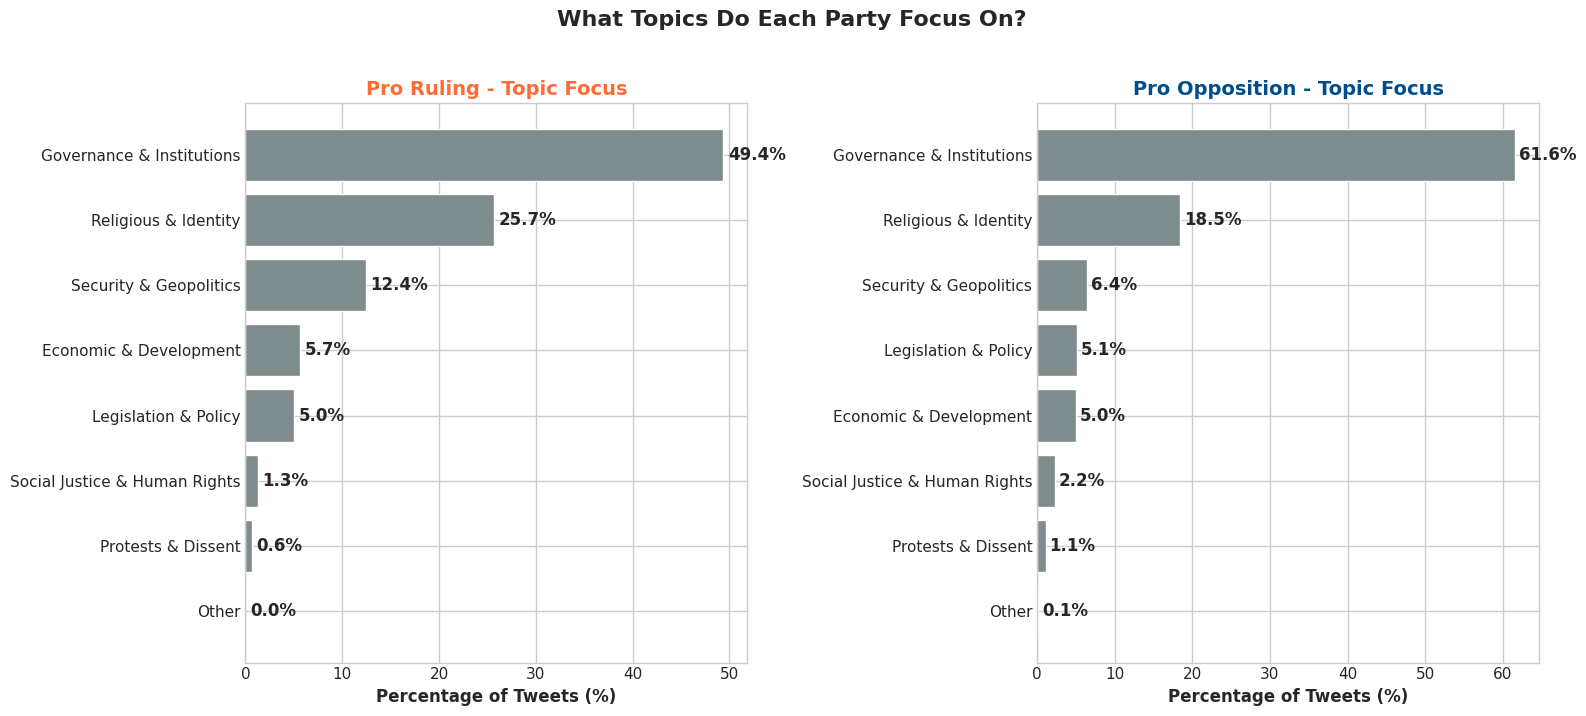

Saved: party_topic_focus.png


In [34]:
# ============================================================================
# PARTY FOCUS BY BUCKET (What topics each party tweets about)
# ============================================================================

bucket_counts = df.groupby(['party', 'bucket']).size().unstack(fill_value=0)
bucket_counts_pct = bucket_counts.div(bucket_counts.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot for each party
for idx, party in enumerate(['pro ruling', 'pro opposition']):
    data = bucket_counts_pct.loc[party].sort_values(ascending=True)
    colors = [BUCKET_COLORS.get(b, '#7f8c8d') for b in data.index]
    
    bars = axes[idx].barh(data.index, data.values, color=colors, edgecolor='white')
    axes[idx].set_xlabel('Percentage of Tweets (%)', fontweight='bold')
    axes[idx].set_title(f'{party.title()} - Topic Focus', fontweight='bold', fontsize=14,
                       color=PARTY_COLORS[party])
    
    # Add value labels
    for bar, val in zip(bars, data.values):
        axes[idx].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                      f'{val:.1f}%', va='center', fontweight='bold')

plt.suptitle('What Topics Do Each Party Focus On?', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('party_topic_focus.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: party_topic_focus.png")

## 6. Per-Keyword Deep Dive

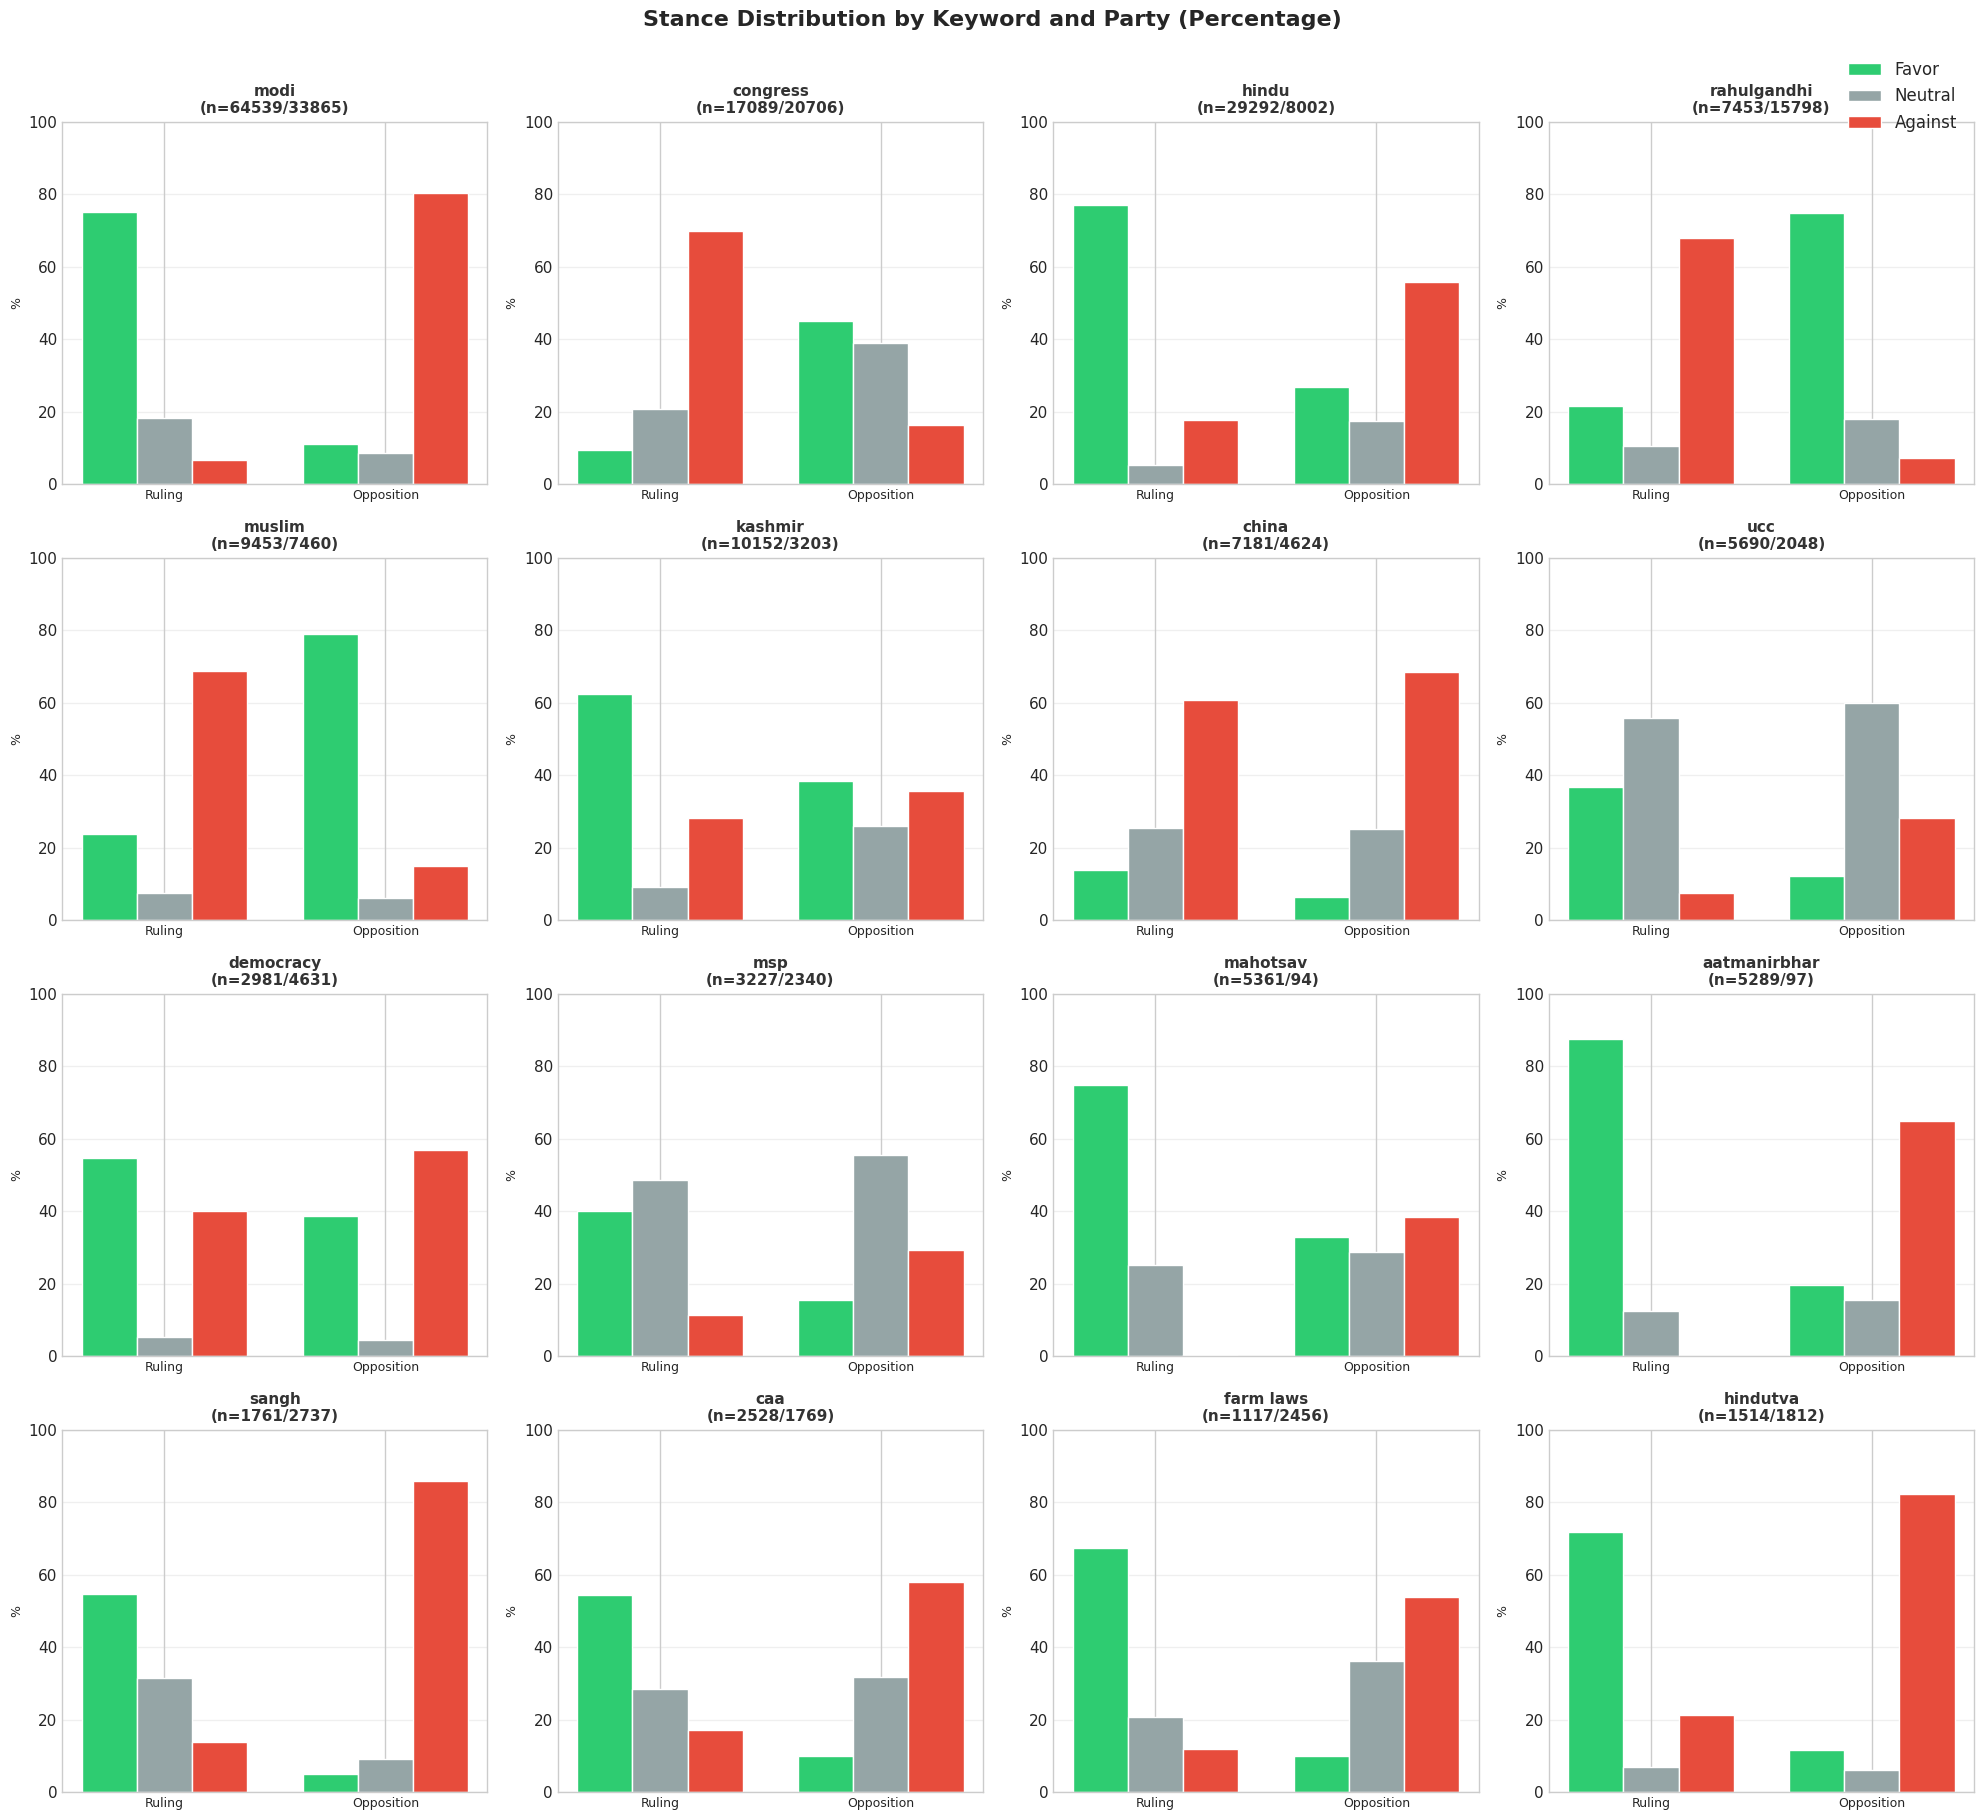

Saved: keyword_breakdown_comparison.png


In [35]:
# ============================================================================
# DETAILED KEYWORD-BY-KEYWORD COMPARISON
# ============================================================================

# Get top keywords by volume
top_keywords = df['keyword'].value_counts().head(16).index.tolist()

fig, axes = plt.subplots(4, 4, figsize=(20, 18))
axes = axes.flatten()

for idx, keyword in enumerate(top_keywords):
    kw_data = df[df['keyword'] == keyword]
    
    # Calculate percentages
    ct = pd.crosstab(kw_data['party'], kw_data['stance'], normalize='index') * 100
    ct = ct.reindex(columns=['favor', 'neutral', 'against'], fill_value=0)
    
    if 'pro ruling' in ct.index and 'pro opposition' in ct.index:
        x = np.arange(2)
        width = 0.25
        
        ruling_data = ct.loc['pro ruling']
        opp_data = ct.loc['pro opposition']
        
        axes[idx].bar(0 - width, ruling_data['favor'], width, color=STANCE_COLORS['favor'])
        axes[idx].bar(0, ruling_data['neutral'], width, color=STANCE_COLORS['neutral'])
        axes[idx].bar(0 + width, ruling_data['against'], width, color=STANCE_COLORS['against'])
        
        axes[idx].bar(1 - width, opp_data['favor'], width, color=STANCE_COLORS['favor'])
        axes[idx].bar(1, opp_data['neutral'], width, color=STANCE_COLORS['neutral'])
        axes[idx].bar(1 + width, opp_data['against'], width, color=STANCE_COLORS['against'])
        
        axes[idx].set_xticks([0, 1])
        axes[idx].set_xticklabels(['Ruling', 'Opposition'], fontsize=9)
        axes[idx].set_ylabel('%', fontsize=9)
        axes[idx].set_ylim(0, 100)
        
        bucket = get_bucket(keyword)
        title_color = BUCKET_COLORS.get(bucket, '#333')
        n_ruling = len(kw_data[kw_data['party'] == 'pro ruling'])
        n_opp = len(kw_data[kw_data['party'] == 'pro opposition'])
        axes[idx].set_title(f"{keyword}\n(n={n_ruling}/{n_opp})", fontweight='bold', 
                           fontsize=11, color=title_color)
        axes[idx].grid(axis='y', alpha=0.3)

# Add legend to last subplot
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=STANCE_COLORS['favor'], label='Favor'),
    Patch(facecolor=STANCE_COLORS['neutral'], label='Neutral'),
    Patch(facecolor=STANCE_COLORS['against'], label='Against')
]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.99, 0.99), fontsize=12)

plt.suptitle('Stance Distribution by Keyword and Party (Percentage)', fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('keyword_breakdown_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: keyword_breakdown_comparison.png")

## 7. Summary Statistics & Export

In [36]:
# ============================================================================
# SUMMARY STATISTICS TABLE
# ============================================================================

summary_df = polarization_df.copy()
summary_df = summary_df.round(2)

# Reorder columns for clarity
summary_df = summary_df[['keyword', 'bucket', 
                         'ruling_count', 'ruling_favor', 'ruling_against', 'ruling_neutral',
                         'opp_count', 'opp_favor', 'opp_against', 'opp_neutral',
                         'polarization_score', 'stance_divergence']]

# Rename for clarity
summary_df.columns = ['Keyword', 'Bucket', 
                      'Ruling_N', 'Ruling_Favor%', 'Ruling_Against%', 'Ruling_Neutral%',
                      'Opp_N', 'Opp_Favor%', 'Opp_Against%', 'Opp_Neutral%',
                      'Polarization', 'Divergence']

print("\n" + "=" * 80)
print("COMPLETE SUMMARY STATISTICS")
print("=" * 80)
display(summary_df.style.background_gradient(subset=['Polarization'], cmap='Reds')
                       .background_gradient(subset=['Ruling_Favor%', 'Opp_Favor%'], cmap='Greens')
                       .background_gradient(subset=['Ruling_Against%', 'Opp_Against%'], cmap='Oranges'))

# Export to CSV
summary_df.to_csv('advanced_stance_summary.csv', index=False)
print("\nSaved: advanced_stance_summary.csv")


COMPLETE SUMMARY STATISTICS


,Keyword,Bucket,Ruling_N,Ruling_Favor%,Ruling_Against%,Ruling_Neutral%,Opp_N,Opp_Favor%,Opp_Against%,Opp_Neutral%,Polarization,Divergence
9,demonetisation,Economic & Development,112,75.000000,16.070000,8.930000,464,7.970000,87.930000,4.090000,138.890000,138.890000
0,modi,Governance & Institutions,64539,75.080000,6.670000,18.250000,33865,11.000000,80.290000,8.710000,137.700000,137.700000
23,aatmanirbhar,Economic & Development,5289,87.410000,0.130000,12.460000,97,19.590000,64.950000,15.460000,132.640000,132.640000
32,new parliament,Governance & Institutions,674,74.780000,3.860000,21.360000,236,6.780000,63.980000,29.240000,128.120000,128.120000
34,ram mandir,Religious & Identity,1337,88.560000,4.710000,6.730000,278,23.020000,62.590000,14.390000,123.410000,123.410000
19,sangh,Religious & Identity,1761,54.630000,13.970000,31.400000,2737,4.930000,85.860000,9.210000,121.590000,121.590000
2,hindutva,Religious & Identity,1514,71.660000,21.330000,7.000000,1812,11.530000,82.400000,6.070000,121.190000,121.190000
30,farmers protests,Protests & Dissent,286,15.380000,67.480000,17.130000,828,74.150000,7.370000,18.480000,118.890000,-118.890000
33,rahulgandhi,Governance & Institutions,7453,21.600000,67.870000,10.530000,15798,74.830000,7.270000,17.910000,113.820000,-113.820000
11,bhakts,Religious & Identity,363,70.800000,25.620000,3.580000,1523,15.360000,81.810000,2.820000,111.630000,111.630000



Saved: advanced_stance_summary.csv


In [37]:
# ============================================================================
# KEY FINDINGS
# ============================================================================

print("\n" + "=" * 80)
print("KEY FINDINGS")
print("=" * 80)

# Most polarizing keyword
most_polar = polarization_df.iloc[0]
print(f"\n🔥 MOST POLARIZING KEYWORD: '{most_polar['keyword']}' (Score: {most_polar['polarization_score']:.1f})")
print(f"   - Pro Ruling: {most_polar['ruling_favor']:.1f}% favor, {most_polar['ruling_against']:.1f}% against")
print(f"   - Pro Opposition: {most_polar['opp_favor']:.1f}% favor, {most_polar['opp_against']:.1f}% against")

# Keywords where ruling favors most
print("\n📈 KEYWORDS PRO RULING FAVORS MOST:")
ruling_favors = polarization_df.nlargest(5, 'ruling_favor')[['keyword', 'ruling_favor', 'opp_favor']]
for _, row in ruling_favors.iterrows():
    print(f"   - {row['keyword']}: Ruling {row['ruling_favor']:.1f}% vs Opp {row['opp_favor']:.1f}%")

# Keywords where opposition favors most
print("\n📉 KEYWORDS PRO OPPOSITION FAVORS MOST:")
opp_favors = polarization_df.nlargest(5, 'opp_favor')[['keyword', 'ruling_favor', 'opp_favor']]
for _, row in opp_favors.iterrows():
    print(f"   - {row['keyword']}: Opp {row['opp_favor']:.1f}% vs Ruling {row['ruling_favor']:.1f}%")

# Bucket summary
print("\n📊 POLARIZATION BY BUCKET:")
bucket_polar = polarization_df.groupby('bucket')['polarization_score'].mean().sort_values(ascending=False)
for bucket, score in bucket_polar.items():
    print(f"   - {bucket}: Avg Polarization Score = {score:.1f}")

print("\n" + "=" * 80)


KEY FINDINGS

🔥 MOST POLARIZING KEYWORD: 'demonetisation' (Score: 138.9)
   - Pro Ruling: 75.0% favor, 16.1% against
   - Pro Opposition: 8.0% favor, 87.9% against

📈 KEYWORDS PRO RULING FAVORS MOST:
   - kashmiri pandits: Ruling 89.4% vs Opp 61.0%
   - ram mandir: Ruling 88.6% vs Opp 23.0%
   - aatmanirbhar: Ruling 87.4% vs Opp 19.6%
   - hindu: Ruling 77.0% vs Opp 26.9%
   - ayodhya: Ruling 75.7% vs Opp 17.7%

📉 KEYWORDS PRO OPPOSITION FAVORS MOST:
   - muslim: Opp 79.0% vs Ruling 23.7%
   - rahulgandhi: Opp 74.8% vs Ruling 21.6%
   - farmers protests: Opp 74.2% vs Ruling 15.4%
   - minorities: Opp 68.9% vs Ruling 56.1%
   - shaheen bagh: Opp 63.5% vs Ruling 14.1%

📊 POLARIZATION BY BUCKET:
   - Protests & Dissent: Avg Polarization Score = 114.2
   - Economic & Development: Avg Polarization Score = 92.0
   - Religious & Identity: Avg Polarization Score = 84.8
   - Governance & Institutions: Avg Polarization Score = 81.1
   - Legislation & Policy: Avg Polarization Score = 76.5
   - S

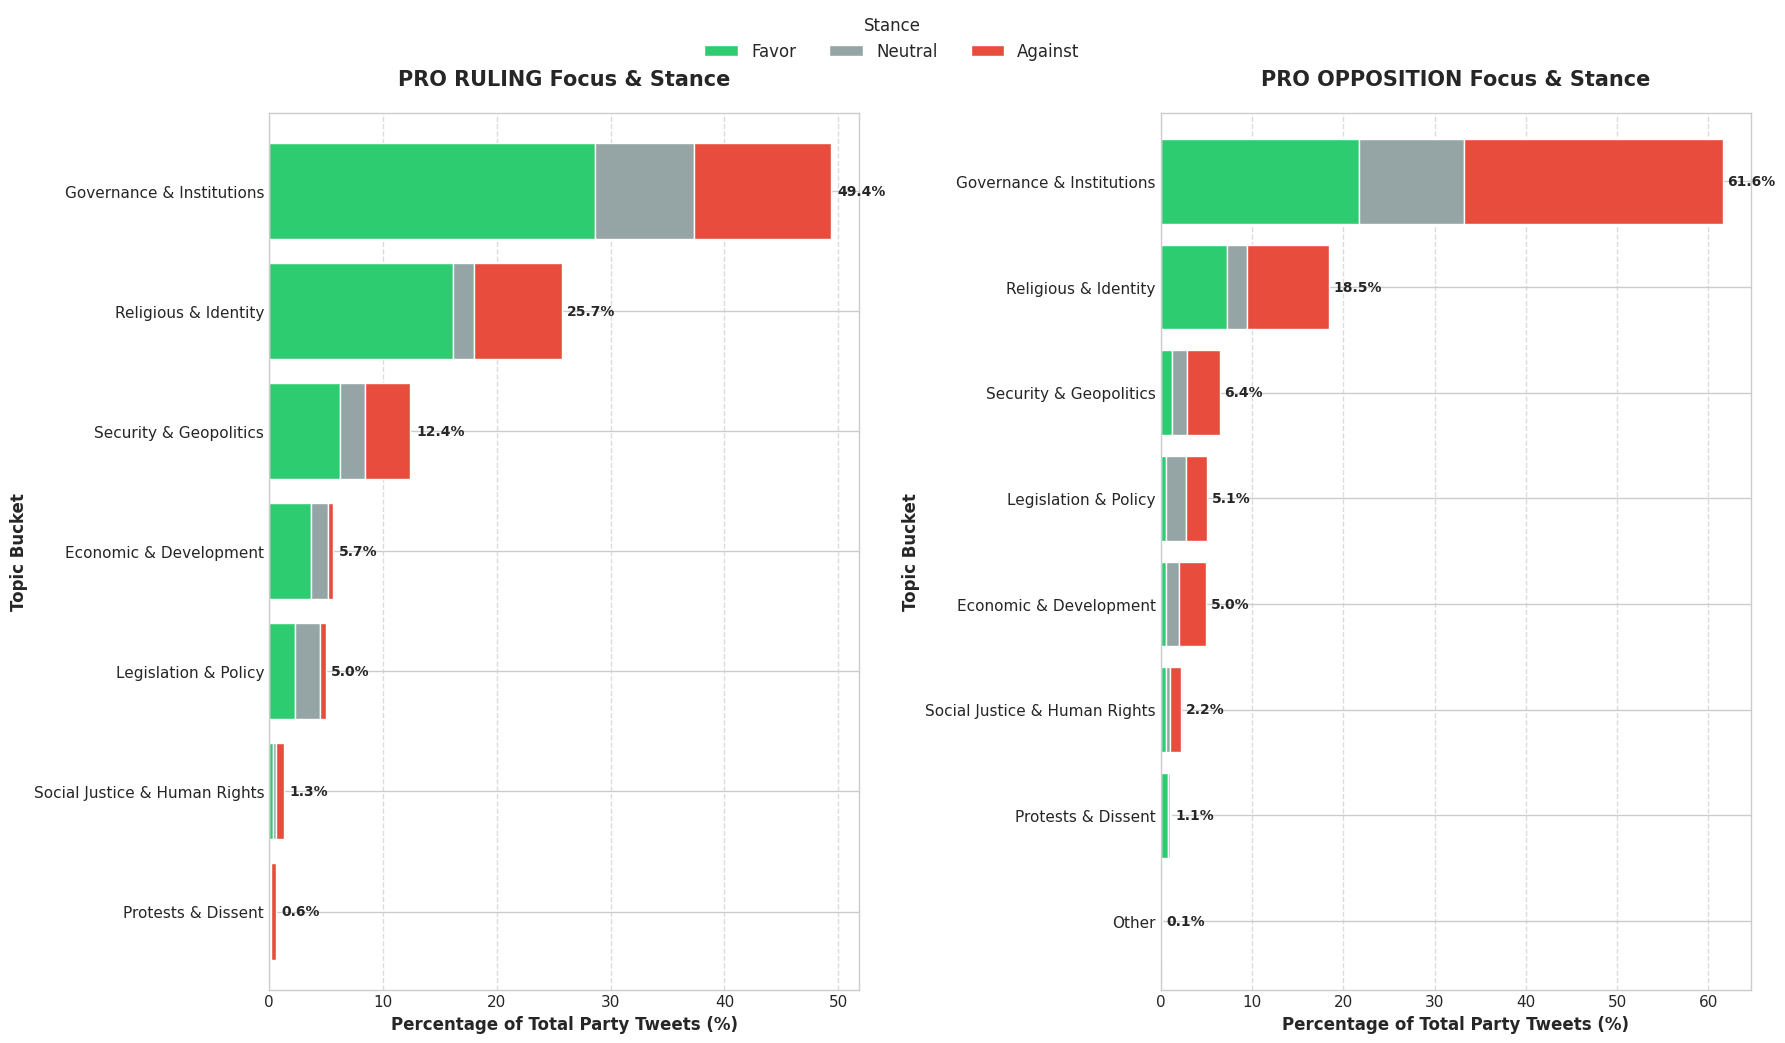

Saved: party_focus_stance_breakdown.png


In [38]:
# ============================================================================
# PARTY FOCUS WITH STANCE BREAKDOWN
# ============================================================================

# 1. Calculate the percentage of total party tweets for each bucket-stance pair
party_totals = df.groupby('party').size()
focus_stance = df.groupby(['party', 'bucket', 'stance']).size().unstack(fill_value=0)

# Normalize by party totals to get % of total party discourse
focus_stance_pct = focus_stance.div(party_totals, axis=0) * 100

fig, axes = plt.subplots(1, 2, figsize=(18, 10), sharey=False)

for idx, party in enumerate(['pro ruling', 'pro opposition']):
    # Filter data for the specific party and sort by total bucket volume
    data = focus_stance_pct.loc[party]
    data['total'] = data.sum(axis=1)
    data = data.sort_values('total', ascending=True)
    data = data.drop(columns=['total'])
    
    # Plot stacked bar
    data[['favor', 'neutral', 'against']].plot(
        kind='barh', 
        stacked=True, 
        ax=axes[idx],
        color=[STANCE_COLORS['favor'], STANCE_COLORS['neutral'], STANCE_COLORS['against']],
        edgecolor='white',
        width=0.8
    )
    
    # Styling
    axes[idx].set_title(f'{party.upper()} Focus & Stance', fontweight='bold', fontsize=15, pad=20)
    axes[idx].set_xlabel('Percentage of Total Party Tweets (%)', fontweight='bold')
    axes[idx].set_ylabel('Topic Bucket', fontweight='bold')
    axes[idx].grid(axis='x', linestyle='--', alpha=0.7)
    
    # Add total volume labels at the end of each bar
    for i, (bucket, row) in enumerate(data.iterrows()):
        total_pct = row.sum()
        axes[idx].text(total_pct + 0.5, i, f'{total_pct:.1f}%', va='center', fontweight='bold', fontsize=10)

# Single legend for the whole figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, [l.capitalize() for l in labels], loc='upper center', 
           bbox_to_anchor=(0.5, 1.05), ncol=3, fontsize=12, title="Stance")

# Remove individual legends
axes[0].get_legend().remove()
axes[1].get_legend().remove()

plt.tight_layout()
plt.savefig('party_focus_stance_breakdown.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: party_focus_stance_breakdown.png")